
---

# Análise Exploratória de Dados de Logística 
Caderno de **Exercícios**<br> 
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Análise Exploratória de Dados de Logística**

##  Pacotes e bibliotecas

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
import json 
import zipfile
import os
import shutil
import geopandas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import warnings 
warnings.filterwarnings('ignore')

## Coleta e Estruturação dos dados

In [2]:
# coletando de dados;
url = "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json"

response = requests.get(url)

with open('dados.json', mode='w', encoding='utf8') as file:
    file.write(response.text)


In [3]:
# transformando em um DataFrame
deliveries_df = pd.read_json('dados.json')

In [4]:
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [5]:
# normalizando a coluna origins
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)


In [6]:
# normalizando a coluna deliveries

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [7]:
len(deliveries_df)

636149

In [8]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## Tratamento dos Dados 

In [9]:
deliveries_df.shape

(636149, 8)

In [10]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [11]:
deliveries_df.describe()

,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
count,636149.000000,636149.000000,636149.0,636149.000000,636149.000000,636149.000000
mean,-47.949902,-15.802359,180.0,5.512111,-47.946087,-15.809492
std,0.091875,0.053463,0.0,2.874557,0.112769,0.082462
min,-48.054989,-15.838145,180.0,1.000000,-48.280779,-16.050028
25%,-48.054989,-15.838145,180.0,3.000000,-48.035911,-15.842795
50%,-47.893662,-15.805118,180.0,6.000000,-47.928967,-15.814033
75%,-47.893662,-15.805118,180.0,8.000000,-47.883394,-15.769516
max,-47.802665,-15.657014,180.0,10.000000,-47.310611,-15.500355


## Geocodificação reversa

In [12]:
# separando as colunas alvos para a geolocalização reversa
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [13]:
# criando o objeto geolocator
geolocator = Nominatim(user_agent="goldoni01")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 14345465,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.6569160",
  "lon": "-47.8026446",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.053411383993285995,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Vila DNOCS, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Vila DNOCS",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state"

In [14]:
# limitando a interação com a API
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [15]:
# concatenando as coluna para fcarem no formato desejado 
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Vila DNOCS, Sobradinho, Regi..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Setor B S..."


In [16]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number,address.quarter
0,14345465,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.6569160,-47.8026446,highway,secondary,26,0.053411,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,14374196,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.8051728,-47.8937235,highway,residential,26,0.053411,...,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN,NaN
2,11624107,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000051,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8,Setor B Sul


In [17]:
# criando um DataFrame com as colunas com a localização dos hubs 
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Vila DNOCS,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga Centro,Taguatinga


In [18]:
# concatenando e removendo as colunas que nãoserão utilizadas
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Vila DNOCS,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga Centro,Taguatinga


In [19]:
# concatenando no DataFrame final
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,7,-48.114898,-15.858055


In [20]:
# Criando o arquivo com as geolocalização baixados offline
url = "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv"

response = requests.get(url)

with open('deliveries-geodata.csv', mode='w', encoding='utf8') as file:
    file.write(response.text)

In [21]:
# Lendo o arquivo 
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [22]:
# concatenando os dados 
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [23]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [24]:
# baixando os arquivo .shp e .shx do site do IBGE
url = "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip"
zip_path = "distrito-federal.zip"
extract_folder = "./maps"

response = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(response.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

shutil.copy(os.path.join(extract_folder, "LIM_Unidade_Federacao_A.shp"), "distrito-federal.shp")
shutil.copy(os.path.join(extract_folder, "LIM_Unidade_Federacao_A.shx"), "distrito-federal.shx")

'distrito-federal.shx'

In [25]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0, -47.31057 -..."


In [26]:
# criando os pontos com as localizações dos hubs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [27]:
# criando os pontos com as localizações das entregas
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.1149 -15.85805)


Text(0.5, 1.0, 'Entregas no Distrito Federal por Região')

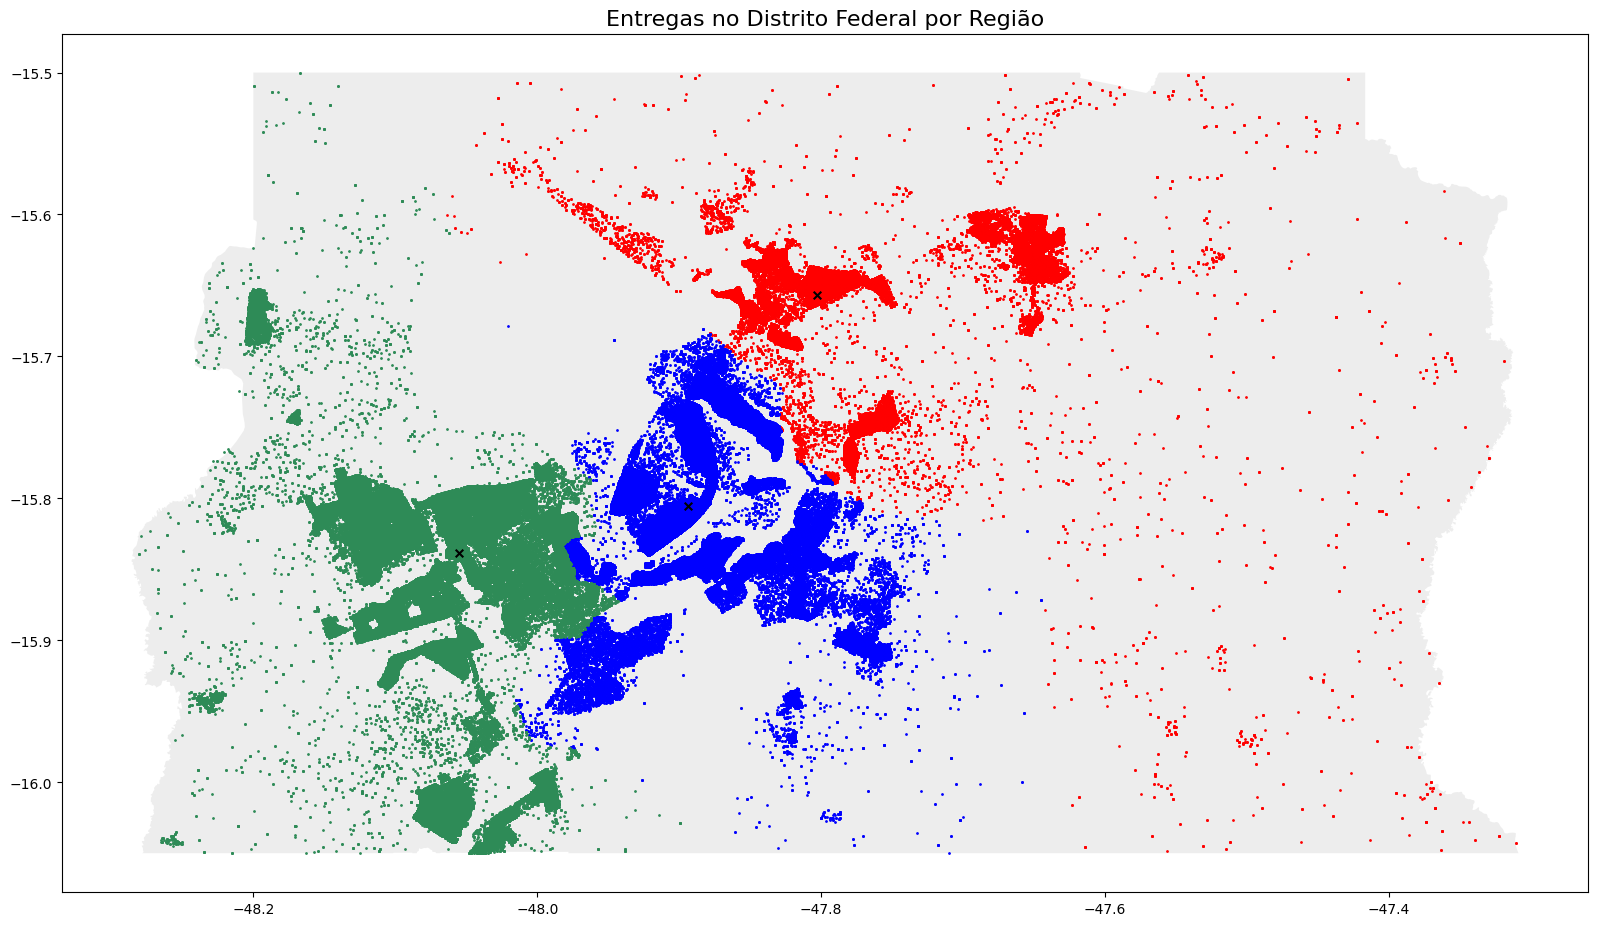

In [28]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})

In [29]:
# proporção da capacidade dos veiculos por região
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


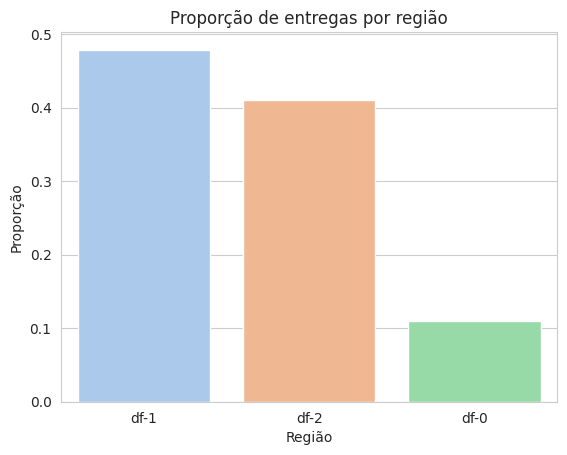

In [30]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

 - **Insights**:

A distribuição das **entregas** está muito concentrada nos **hubs** das regiões 1 e 2, mas pouco no da região 0. Contudo a capacidade dos veículos é mesma para todos os **hubs**, logo os **veículos** poderiam ser deslocados para as regiões de maior tráfego.